# Modeling

The modeling phase aims to build and evaluate models that support the business objectives, using the analysis ready dataset produced in the `Data Preparation` phase

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.10.1


In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

input_dir = "../data/processed/"
pkl_path = os.path.join(input_dir, "prepared_art500k_subset_paintings.pkl")

df = pd.read_pickle(pkl_path)

print(f"DataFrame loaded from {pkl_path}")
print(df.info())

DataFrame loaded from ../data/processed/prepared_art500k_subset_paintings.pkl
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 800 non-null    int64 
 1   image_path         800 non-null    object
 2   type_landscape     800 non-null    bool  
 3   type_mythological  800 non-null    bool  
 4   type_portrait      800 non-null    bool  
 5   type_religious     800 non-null    bool  
dtypes: bool(4), int64(1), object(1)
memory usage: 15.8+ KB
None


## Select modeling technique

### Modeling technique
With the limited dataset, transfer learning will be used first. The GPU can be used for tensorflow/keras. One of the models in [keras.io/api/applications](https://keras.io/api/applications/) will be chosen.

The XCeption model has been selected to make a first iteration due to strong accuracy on ImageNet. Besides this is it also suitable for the local GPU

### Modeling assumptions
**Input shape:**
- All input images must be resized to the target dimensions (299x299, 3 channels)
- Images must be preprocessed with `keras.applications.xception.preprocess_input` before input to the model (scaling to [-1, 1]).

**Labels:**
- The number of output classes matches the unique values of the `TYPE` variable (4)

**Dataset Size:**
- Transfer learning with a pre-trained backbone assumes a moderate or small labeled dataset

**Distribution:**
- Model does not require input features to be normally distributed, but assumes the label distribution is sufficiently balanced for meaningful evaluation.

**Augmentation:**
- To enhance generalization, basic image augmentation (random flip, rotation, etc.) can be applied during training if the model performs poorly [keras.io/guides_transfer_learning](https://keras.io/guides/transfer_learning/)

## Test design
in the data preperation step the label was taken out of the dataframe. Now it needs to be added back

In [3]:
onehot_cols = ['type_landscape', 'type_mythological', 'type_portrait', 'type_religious']

# Convert one-hot to class label
df['label'] = np.argmax(df[onehot_cols].values, axis=1)
index_to_type = {i: col.replace('type_', '') for i, col in enumerate(onehot_cols)}
df['label_name'] = df['label'].map(index_to_type)

In [4]:
df.sample(n=5, random_state=SEED)

,id,image_path,type_landscape,type_mythological,type_portrait,type_religious,label,label_name
696,36504,../data/toy_dataset/36504.jpg,True,False,False,False,0,landscape
667,13794,../data/toy_dataset/13794.jpg,False,True,False,False,1,mythological
63,42302,../data/toy_dataset/42302.jpg,False,True,False,False,1,mythological
533,5216,../data/toy_dataset/5216.jpg,False,False,False,True,3,religious
66,25391,../data/toy_dataset/25391.jpg,True,False,False,False,0,landscape


Using stratification so all train/validation/test splits have relative proportions of each label. a split of 

In [5]:
# 80/20
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

# 50/50 of the 20%
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=SEED
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(validation_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 640
Validation samples: 80
Test samples: 80


## Build model

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE
ONE_HOT_DIMENSIONS = 4
DROPOUT_RATE = 0.2

Function to parse images on teh fly

In [7]:
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = keras.applications.xception.preprocess_input(image)
    return image, label

Create TensorFlow Datasets from DataFrame slices

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

validation_ds = tf.data.Dataset.from_tensor_slices(
    (validation_df['image_path'].values, validation_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['image_path'].values, test_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

Load the XCeption model

In [9]:
keras.backend.clear_session()

base_model = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

Build model head

In [10]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
model = keras.Model(inputs, outputs)

Compile model

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_____________________________________________

Train the model

In [12]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
20/20 [==============================] - 11s 318ms/step - loss: 1.1427 - accuracy: 0.4984 - val_loss: 0.9533 - val_accuracy: 0.6500
Epoch 2/10
20/20 [==============================] - 6s 288ms/step - loss: 0.7636 - accuracy: 0.7563 - val_loss: 0.8083 - val_accuracy: 0.7125
Epoch 3/10
20/20 [==============================] - 6s 289ms/step - loss: 0.6284 - accuracy: 0.7844 - val_loss: 0.7661 - val_accuracy: 0.7250
Epoch 4/10
20/20 [==============================] - 6s 288ms/step - loss: 0.5538 - accuracy: 0.8094 - val_loss: 0.7463 - val_accuracy: 0.7250
Epoch 5/10
20/20 [==============================] - 6s 289ms/step - loss: 0.5089 - accuracy: 0.8313 - val_loss: 0.7351 - val_accuracy: 0.7625
Epoch 6/10
20/20 [==============================] - 6s 300ms/step - loss: 0.4713 - accuracy: 0.8344 - val_loss: 0.7269 - val_accuracy: 0.7500
Epoch 7/10
20/20 [==============================] - 6s 320ms/step - loss: 0.4455 - accuracy: 0.8438 - val_loss: 0.7218 - val_accuracy: 0.7625
Epoch

### Loss plot

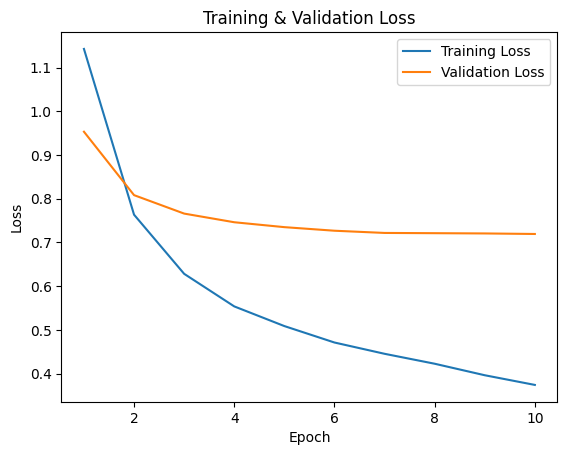

In [13]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

From this plot the conclusion can be made that the model is learning but the ability to generalise is being lost over the epochs. The gap between the training and validation loss keeps increasing.

A possible next step could be to stop training as soon as validation loss levels off. The dropout rate could also help improve performance. Augmenting the data could still be of use with this limited dataset

### Accuracy plot

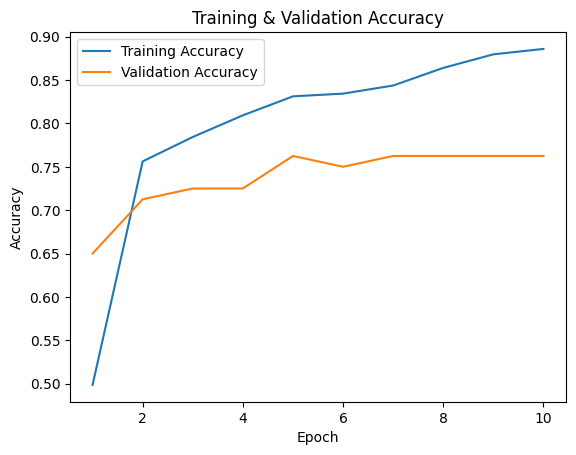

In [14]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This plot reinforces what was seen in the loss plot

In [15]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 1s 228ms/step - loss: 0.5480 - accuracy: 0.7500
Test accuracy: 0.750


The accuracy is already quite good for the limited size of the dataset

It is intersting to create two new models with transferlearning and augment the data in one and adjust the dropout rate with the other model

## Model B

For this model only the following will be different
- Added data augmentation with:
  - horizontal flip
  - 0.1 rotation
  - 0.1 zoom

### Augmentation layer

In [16]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")

In [17]:
train_dsB = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    # NEW: augment only during training
    .map(lambda x, y: (augmentation_layers(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
modelB = keras.Model(inputs, outputs)

In [18]:
modelB.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modelB.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
___________________________________________

In [19]:
historyB = modelB.fit(
    train_dsB,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
20/20 [==============================] - 10s 392ms/step - loss: 1.1947 - accuracy: 0.4969 - val_loss: 1.0284 - val_accuracy: 0.6375
Epoch 2/10
20/20 [==============================] - 7s 373ms/step - loss: 0.8455 - accuracy: 0.6891 - val_loss: 0.8950 - val_accuracy: 0.6750
Epoch 3/10
20/20 [==============================] - 8s 375ms/step - loss: 0.7246 - accuracy: 0.7422 - val_loss: 0.8385 - val_accuracy: 0.6875
Epoch 4/10
20/20 [==============================] - 8s 377ms/step - loss: 0.6389 - accuracy: 0.7453 - val_loss: 0.8285 - val_accuracy: 0.6875
Epoch 5/10
20/20 [==============================] - 8s 379ms/step - loss: 0.6033 - accuracy: 0.7937 - val_loss: 0.8043 - val_accuracy: 0.6875
Epoch 6/10
20/20 [==============================] - 8s 382ms/step - loss: 0.5703 - accuracy: 0.7937 - val_loss: 0.8003 - val_accuracy: 0.7000
Epoch 7/10
20/20 [==============================] - 8s 392ms/step - loss: 0.5574 - accuracy: 0.8016 - val_loss: 0.7993 - val_accuracy: 0.7125
Epoch

### Accuracy plot comparison
Comparison of Model A and Model B

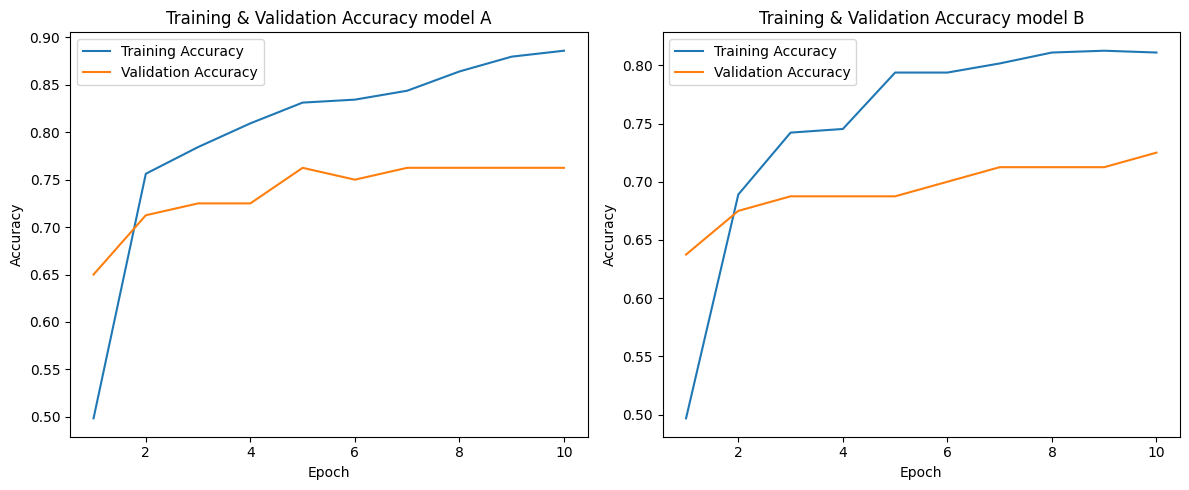

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history.history['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training & Validation Accuracy model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, historyB.history['accuracy'], label='Training Accuracy')
axs[1].plot(epochs, historyB.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training & Validation Accuracy model B')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Model A shows better overall performance with both training and validation accuracy increasing. Validation accuracy tops at around 0.76.
Model B training accuracy steadily improves and begins to plateau a little above 0.80 while validation accuracy increases more slowly and levels off near 0.72.

### Loss plot comparison

Comparison of Model A and Model B

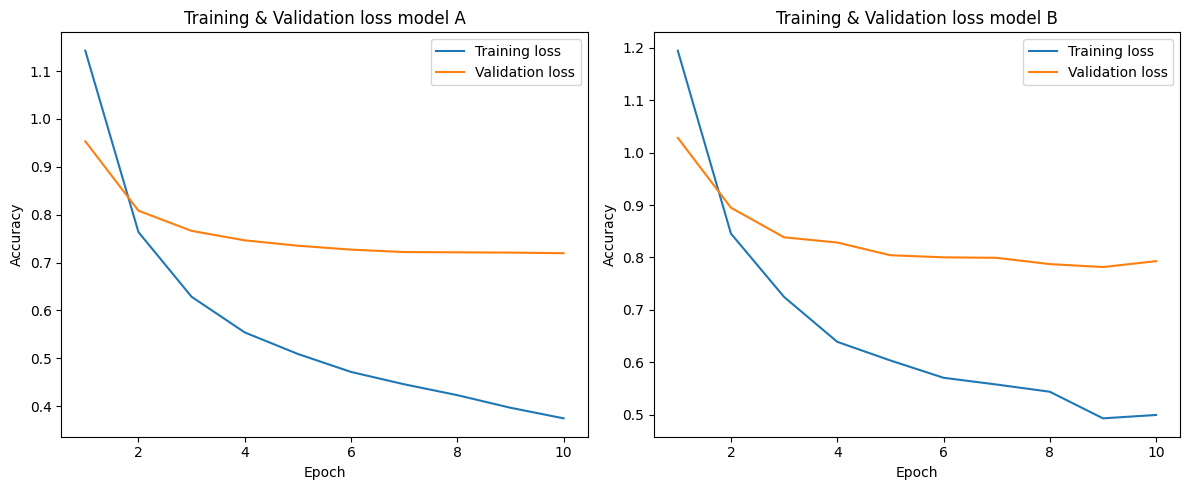

In [29]:
# Same amount of epochs for both models
epochs = range(1, len(history.history['loss']) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history.history['loss'], label='Training loss')
axs[0].plot(epochs, history.history['val_loss'], label='Validation loss')
axs[0].set_title('Training & Validation loss model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, historyB.history['loss'], label='Training loss')
axs[1].plot(epochs, historyB.history['val_loss'], label='Validation loss')
axs[1].set_title('Training & Validation loss model B')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Model A shows a steady decrease in training loss but the validation loss plateaus early and remains higher. Model B also shows decreasing training loss but the validation loss decreases more slowly and even slightly increases after epoch 9 suggesting it may be struggling to generalize.

In [21]:
test_loss, test_acc = modelB.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 1s 222ms/step - loss: 0.6398 - accuracy: 0.7500
Test accuracy: 0.750


## Model C
For this model only the dropout_rate will be set to a higher value

In [22]:
DROPOUT_RATE = 0.5

In [23]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
modelC = keras.Model(inputs, outputs)

In [24]:
modelC.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modelC.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
___________________________________________

In [25]:
historyC = modelC.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
20/20 [==============================] - 13s 387ms/step - loss: 1.1685 - accuracy: 0.4672 - val_loss: 0.9702 - val_accuracy: 0.6500
Epoch 2/10
20/20 [==============================] - 6s 302ms/step - loss: 0.8141 - accuracy: 0.7141 - val_loss: 0.8287 - val_accuracy: 0.6500
Epoch 3/10
20/20 [==============================] - 6s 312ms/step - loss: 0.6734 - accuracy: 0.7469 - val_loss: 0.7817 - val_accuracy: 0.6500
Epoch 4/10
20/20 [==============================] - 6s 309ms/step - loss: 0.6203 - accuracy: 0.7875 - val_loss: 0.7661 - val_accuracy: 0.6750
Epoch 5/10
20/20 [==============================] - 6s 313ms/step - loss: 0.5449 - accuracy: 0.7969 - val_loss: 0.7486 - val_accuracy: 0.6625
Epoch 6/10
20/20 [==============================] - 6s 304ms/step - loss: 0.5396 - accuracy: 0.8000 - val_loss: 0.7437 - val_accuracy: 0.6875
Epoch 7/10
20/20 [==============================] - 6s 303ms/step - loss: 0.4938 - accuracy: 0.8203 - val_loss: 0.7418 - val_accuracy: 0.7375
Epoch

### Accuracy plot comparison
Comparison of Model A and Model C

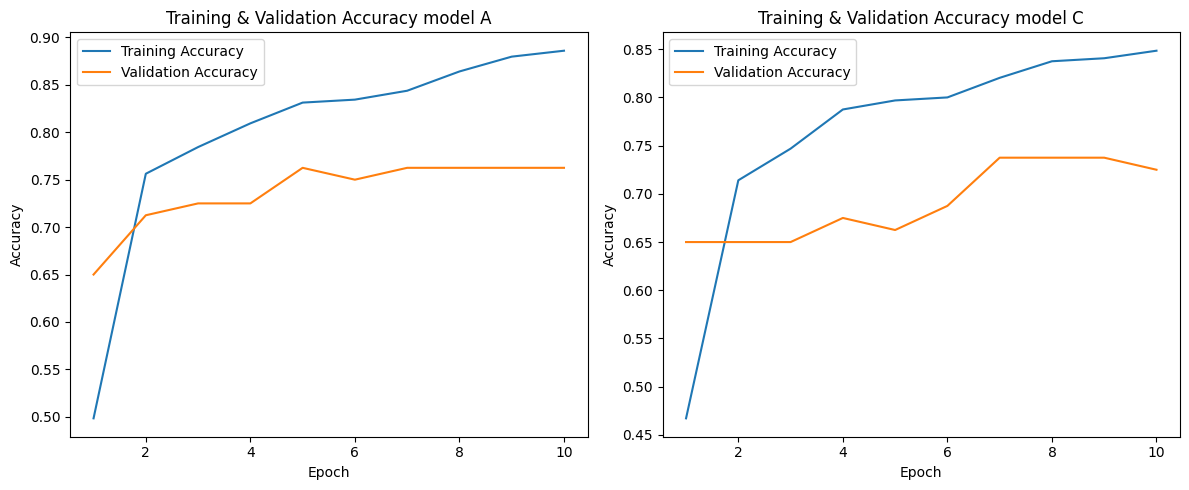

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history.history['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training & Validation Accuracy model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, historyC.history['accuracy'], label='Training Accuracy')
axs[1].plot(epochs, historyC.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training & Validation Accuracy model C')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Model A shows better overall performance with both training and validation accuracy increasing. Validation accuracy tops at around 0.76. Model C has lower training and validation accuracy with validation accuracy stagnating and even slightly dropping after epoch 9.

## Loss plot comparison

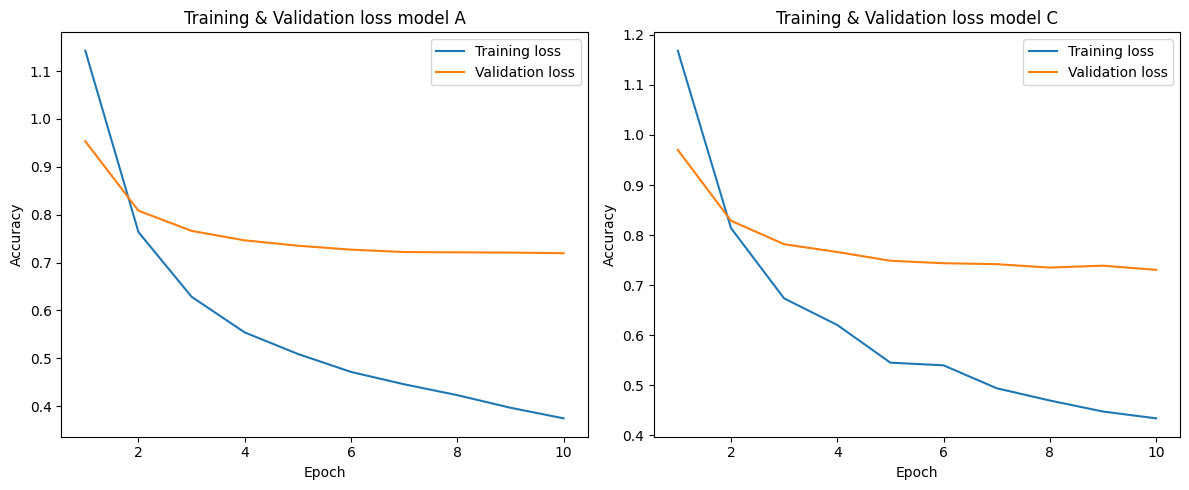

In [30]:
# Same amount of epochs for both models
epochs = range(1, len(history.history['loss']) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history.history['loss'], label='Training loss')
axs[0].plot(epochs, history.history['val_loss'], label='Validation loss')
axs[0].set_title('Training & Validation loss model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, historyC.history['loss'], label='Training loss')
axs[1].plot(epochs, historyC.history['val_loss'], label='Validation loss')
axs[1].set_title('Training & Validation loss model C')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Model A shows a steady decrease in training loss but the validation loss plateaus early and remains higher. Model C shows both training and validation loss decreasing steadily suggesting better generalization and less overfitting compared to Model A but this is only slightly.

In [27]:
test_loss, test_acc = modelC.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 1s 195ms/step - loss: 0.5155 - accuracy: 0.8000
Test accuracy: 0.800


# Asses Models

During this modelling phase 3 models are created.

General value for all models
- base model: Xception

- Training samples: 640
- Validation samples: 80
- Test samples: 80

- BATCH_SIZE = 32
- IMG_SIZE = (299, 299)
- EPOCHS = 10
- AUTOTUNE = tf.data.AUTOTUNE
- ONE_HOT_DIMENSIONS = 4

**Model A**
- DROPOUT_RATE = 0.2
- accuracy on test set: 0.750
- model fit time: 1m 6.8s

**Model B**
- DROPOUT_RATE = 0.2
- Image agumentation added [keras.layers.RandomFlip("horizontal"), .RandomRotation(0.1), .RandomZoom(0.1)]
- accuracy on test set: 0.712
- model fit time: 1m 20.4s


**Model C**
- DROPOUT_RATE = 0.4
- accuracy on test set: 0.800
- model fit time: 1m 8.4s

## Conclusion
Model C clearly performs best overall, achieving the highest test accuracy of 0.800. This indicates better generalization despite a higher dropout rate which likely helps reduce overfitting.
Model A follows with a solid test accuracy of 0.750
Model B performs despite including image augmentation worst with a test accuracy of 0.712 and slower training time possibly due to the added complexity from augmentation not translating into better generalization here.

## Save for evaluation
Save the model, history and test data for further evaluation

In [ ]:
output_dir = "../model/iteration_0/"
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "cnn_model.h5")

modelC.save(model_path)
print("Model C saved successfully")

Model C saved successfully.


In [ ]:
import pickle

with open('../model/iteration_0/training_history.pkl', 'wb') as f:
    pickle.dump(historyC.history, f)
print("Training history saved successfully")

Training history saved successfully.


In [34]:
test_df.to_pickle('../model/iteration_0/test_df.pkl')
print("Test DataFrame saved as pickle")

Test DataFrame saved as pickle
